In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
raw_atlas = pd.read_csv('../data/processed/processed_atlas_2019.csv')
pd.set_option('display.max_columns', None)
print(f'Column amt: {len(raw_atlas.columns)}')

Column amt: 21


In [4]:
raw_atlas.head()

,Unnamed: 0,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lakids1share,laseniors1share,lahunv1share,lalowi1share,POP2010,CensusTract,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,0,1.0,11.3,0.318183,0.036220,0.042803,0.012796,0.000990,0.046897,99.19,26.33,11.44,0.79,24.11,0.051027,1001020100,0.237971,0.053347,0.003138,0.294456,0.006762
1,1,1.0,17.9,0.187881,0.063843,0.051161,0.012391,0.014689,0.071724,58.11,18.69,5.83,9.00,27.83,0.057916,1001020200,0.369585,0.071889,0.041014,0.482488,0.018882
2,2,1.0,15.0,0.242867,0.103964,0.075475,0.025418,0.016339,0.079080,46.00,12.34,5.96,0.00,14.18,0.090038,1001020300,0.387192,0.050993,0.029351,0.467536,0.025766
3,3,1.0,2.8,0.275182,0.073396,0.085690,0.052342,0.003466,0.045057,31.09,7.89,5.39,0.46,7.83,0.117086,1001020400,0.210214,0.022344,0.004788,0.237346,0.003395
4,4,1.0,15.2,0.379128,0.178475,0.266948,0.065196,0.037960,0.155862,24.55,6.64,3.36,1.35,5.45,0.287442,1001020500,0.208248,0.031488,0.021364,0.261100,0.044822


In [28]:
scale_cols = [
    "MedianFamilyIncome", "TractLOWI", "TractKids", "TractSeniors",
    "TractHUNV", "TractSNAP", "LOWIWeighted",
    "lapop1share", "lakids1share", "laseniors1share", 
    "lahunv1share", "lalowi1share", "POP2010",
    "LOWIRatio", "SNAPRatio", "HUNVRatio", "FoodInsecurityIndex", "PovertyRate"
]

In [29]:
scaler = MinMaxScaler()
scaled_atlas = raw_atlas.copy()
scaled_atlas
scaled_atlas[scale_cols] = scaler.fit_transform(scaled_atlas[scale_cols])

In [30]:
input_columns = [
    'Urban', 'PovertyRate', 'MedianFamilyIncome', 'TractLOWI', 'TractKids', 'TractSeniors',
    'TractHUNV', 'TractSNAP', 'lapop1share', 'laseniors1share', 'lahunv1share', 
    'POP2010', 'LOWIRatio', 'SNAPRatio', 'HUNVRatio', 'FoodInsecurityIndex', 'LOWIWeighted' 
]

In [31]:
class Autoencoder_Food_Desert_Model(nn.Module):
    def __init__(self, input_dim=17, latent_dim=8):
        super(Autoencoder_Food_Desert_Model, self).__init__()
        
        #Encode our dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 12),
            nn.ReLU(True),
            nn.Linear(12, latent_dim)
        )
        
        #Decoding these dimensions
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(True),
            nn.Linear(12, 16),
            nn.ReLU(True),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        encoding_result = self.encoder(input)
        decoding_output = self.decoder(encoding_result)
        return decoding_output


In [32]:
atlas_tensor = torch.tensor(scaled_atlas[input_columns].to_numpy(), dtype=torch.float32)
atlas_tensor.shape

torch.Size([72531, 17])

In [33]:
print(torch.min(atlas_tensor), torch.max(atlas_tensor))

tensor(0.) tensor(1.)


In [36]:
scaled_atlas.head()

,Unnamed: 0,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lakids1share,laseniors1share,lahunv1share,lalowi1share,POP2010,CensusTract,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,LOWIWeighted
0,0,1.0,0.113,0.318183,0.036220,0.042803,0.012796,0.000990,0.046897,0.9919,0.289978,0.1144,0.0079,0.2411,0.051027,1001020100,0.007051,0.022840,0.000292,0.008725,0.006762
1,1,1.0,0.179,0.187881,0.063843,0.051161,0.012391,0.014689,0.071724,0.5811,0.205837,0.0583,0.0900,0.2783,0.057916,1001020200,0.010951,0.030778,0.003815,0.014296,0.018882
2,2,1.0,0.150,0.242867,0.103964,0.075475,0.025418,0.016339,0.079080,0.4600,0.135903,0.0596,0.0000,0.1418,0.090038,1001020300,0.011472,0.021832,0.002730,0.013853,0.025766
3,3,1.0,0.028,0.275182,0.073396,0.085690,0.052342,0.003466,0.045057,0.3109,0.086894,0.0539,0.0046,0.0783,0.117086,1001020400,0.006229,0.009566,0.000445,0.007032,0.003395
4,4,1.0,0.152,0.379128,0.178475,0.266948,0.065196,0.037960,0.155862,0.2455,0.073128,0.0336,0.0135,0.0545,0.287442,1001020500,0.006170,0.013481,0.001987,0.007736,0.044822


In [37]:
for col in input_columns:
    max_val = scaled_atlas[col].max()
    if max_val > 1:
        print(f"{col}: MAX = {max_val}")


In [38]:
train_size = int(0.9 * len(atlas_tensor))
val_size = len(atlas_tensor) - train_size
train_dataset, val_dataset = random_split(atlas_tensor, [train_size, val_size])

In [39]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [40]:
model = Autoencoder_Food_Desert_Model(input_dim=17, latent_dim=8).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

In [41]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
                
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader.dataset):.6f} | Val Loss: {val_loss/len(val_loader.dataset):.6f}")

Epoch 1/50 | Train Loss: 0.009569 | Val Loss: 0.005297
Epoch 2/50 | Train Loss: 0.002697 | Val Loss: 0.001605
Epoch 3/50 | Train Loss: 0.001283 | Val Loss: 0.001376
Epoch 4/50 | Train Loss: 0.001221 | Val Loss: 0.001235
Epoch 5/50 | Train Loss: 0.001160 | Val Loss: 0.001088
Epoch 6/50 | Train Loss: 0.000919 | Val Loss: 0.000977
Epoch 7/50 | Train Loss: 0.000882 | Val Loss: 0.000843
Epoch 8/50 | Train Loss: 0.000739 | Val Loss: 0.000731
Epoch 9/50 | Train Loss: 0.000729 | Val Loss: 0.000721
Epoch 10/50 | Train Loss: 0.000542 | Val Loss: 0.000629
Epoch 11/50 | Train Loss: 0.000533 | Val Loss: 0.000567
Epoch 12/50 | Train Loss: 0.000514 | Val Loss: 0.000582
Epoch 13/50 | Train Loss: 0.000467 | Val Loss: 0.000548
Epoch 14/50 | Train Loss: 0.000483 | Val Loss: 0.000474
Epoch 15/50 | Train Loss: 0.000439 | Val Loss: 0.000459
Epoch 16/50 | Train Loss: 0.000406 | Val Loss: 0.000408
Epoch 17/50 | Train Loss: 0.000340 | Val Loss: 0.000338
Epoch 18/50 | Train Loss: 0.000344 | Val Loss: 0.000324
E

In [42]:
model.eval()
with torch.no_grad():
    latent_vectors = model.encoder(atlas_tensor.to(device)).cpu().numpy()

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors)

In [44]:
clustered_df = raw_atlas.copy()
clustered_df['Cluster'] = cluster_labels

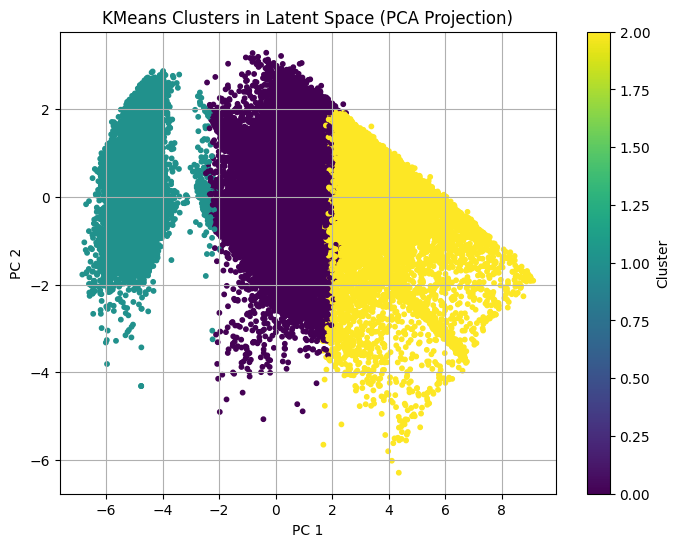

In [45]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('KMeans Clusters in Latent Space (PCA Projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

In [48]:
clustered_df.groupby('Cluster').mean(numeric_only=True)[[
    'PovertyRate', 'SNAPRatio', 'LOWIRatio', 'HUNVRatio', 
    'TractKids', 'TractSeniors', 'TractHUNV', 'TractSNAP', 
    'MedianFamilyIncome', 'FoodInsecurityIndex', 'LOWIWeighted'
]]


,PovertyRate,SNAPRatio,LOWIRatio,HUNVRatio,TractKids,TractSeniors,TractHUNV,TractSNAP,MedianFamilyIncome,FoodInsecurityIndex,LOWIWeighted
Cluster,,,,,,,,,,,
0,19.980332,0.068577,0.416689,0.051830,0.090118,0.029932,0.032233,0.124627,0.239642,0.537095,0.052832
1,13.778356,0.044502,0.322409,0.018637,0.081847,0.034672,0.011972,0.081403,0.272220,0.385548,0.028449
2,8.486489,0.027262,0.215099,0.031442,0.083930,0.033648,0.019663,0.049972,0.425648,0.273804,0.012755


In [54]:
clustered_df_cols = ['CensusTract', 'Cluster']
save_clustered_df = clustered_df[clustered_df_cols]
save_clustered_df.head()

,CensusTract,Cluster
0,1001020100,0
1,1001020200,0
2,1001020300,0
3,1001020400,2
4,1001020500,2


In [55]:
save_clustered_df.to_csv('../data/processed/clustered_atlas_labels.csv', index=False)